![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
Welcome to The QuantConnect Research Page!

Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter

Contribute to this file https://github.com/QuantConnect/Research/tree/master/Notebooks

## Pairs Trading Based on Cointegration
In this research we will demonstrate a pairs trading strategy based on cointegration. Refer to this research notebook for details about cointegration pairs trading method.

https://github.com/QuantConnect/Research/blob/master/Notebooks/03%20Kalman%20Filter%20Based%20Pairs%20Trading.ipynb

- Check the algorithm implemented on LEAN

https://www.quantconnect.com/terminal/processCache?request=embedded_backtest_d6e655d4d158c4043eef8926a72c75f5.html

Here we ignore the fees when we generate the profit curve so the statistics result might be slightly different from the LEAN implementation.

In [37]:
%matplotlib inline
# Imports
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
# Create an instance
qb = QuantBook()
# plt.style.available

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
plt.style.use('seaborn-whitegrid')
from sklearn import linear_model

### Step 0:
First we define some functions that we need to generate the equity curve.

In [39]:
def calculateQuantity(signal, price, cash):
    """
    This function calculate the quantity based on the signal and initial cash 
    
    Parameters:
            signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)
            price(pandas.Series) : The price series of stock indexed by date
            cash(float): The total cash for trading
    
    Returns(pandas.Series):
            quantity(pandas.Series): The number of holding shares indexed by date 
    """

    index = np.where(signal.shift(1) != signal)[0][1:]
    quantity_temp = floor(cash/price[0])
    cash_left_temp = cash
    quantity = [quantity_temp] #* len(signal)
    cash_left = [cash_left_temp] #* len(signal)

    for i in range(1,len(price)):
        if i in index:
            if signal[i-1] * signal[i] == -1:
                cash_left_liquidate = cash_left[i-1] + (signal[i-1]- 0) * quantity[-1] * price[i]                    
                quantity_temp = floor(cash_left_liquidate / price[i])
                cash_left_temp = cash_left_liquidate + (0 - signal[i]) * quantity_temp * price[i] 
 
                if quantity_temp == 0:
                    # print("{0} Order Failed (No enough money)  Cash left: {1} share price: {2}".format(signal.index[i],cash_left_temp,price[i]))                    
                    quantity_temp =  quantity[i-1]
                
                if cash_left_liquidate < 0:
                    quantity_temp = 0
                                         
            elif signal[i-1] * signal[i] == 0:
                quantity_temp = floor(cash_left[i-1] / price[i])
                cash_left_temp = cash_left[i-1] + (signal[i-1]- signal[i]) * quantity_temp * price[i]        
                    
                if quantity_temp == 0:
                    # print("{0} Order Failed (No enough money)  Cash left: {1} share price: {2}".format(signal.index[i],cash_left_temp,price[i]))
                    quantity_temp =  quantity[i-1]
                       
        quantity.append(quantity_temp)
        cash_left.append(cash_left_temp)
   
    return pd.Series(quantity, index = signal.index)

In [40]:
class NetProfit:
    """
    This class calculates the net profit for strategy trading individual stock
    
    Args:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)

    Attributes:
        price(pandas.Series) : The price series of stock indexed by date
        signal(pandas.Series): The trading signal series of stock indexed by date (long 1, short -1, holding 0)
        quantity(pandas.Series): The number of holding shares indexed by date 
    
    Note:
        If there is no quantity, the default value of quantity is 1 share at each time step)       
    """
    
    def __init__(self, price, signal):
        self.price = price
        self.signal = signal
        self.quantity = pd.Series([1]*len(self.price),index = self.price.index)
        
        
    def net_profit(self):
       
        """
        calculate the net profit
        
        Returns(pandas.Series):
                The net profit for strategy        
        """
        #   log_return = np.log(self.price/self.price.shift(1))
        #   cum_return = np.exp(((log_return)*self.signal.shift(1)).cumsum())*self.quantity
        pct_return = self.price.pct_change()
        cum_return = ((pct_return)*self.signal.shift(1) + 1).cumprod()*self.quantity 
        net_profit = cum_return.dropna()*self.price[0] #- self.quantity * self.price[0]

        return net_profit   
    
class PortfolioNetProfit:
    """
    This class calculates the net profit for strategy trading a porfolio of stocks or singal stock
    
    Args:
        data(dict): A dictionary stores the data for multiple stocks 
                    keys(string): 
                                symbols
                    values(dataframe): 
                                Index: date 
                                Columns: ['price','signal','quantity'] or ['price','signal']         
    """
    
    def __init__(self,data):
        self.data = data
        
    def net_profit(self):
        """
        Calculate the net profit for the portfolio
        
        Returns(pandas.Series):
                The net profit for strategy
            
        """
        dataframe = self.data[self.data.keys()[0]]
        net_profit_port = pd.Series([0]*(len(dataframe)),index = dataframe.index)
       
        for i in self.data:
            df = self.data[i]
            net_profit_each = NetProfit(df['price'],df['signal'])
            try:
                net_profit_each.quantity = df['quantity'] # if there is no quantity, the default is 1 
            except:
                pass
            cum_return = net_profit_each.net_profit()
            net_profit_port = net_profit_port.add(cum_return,fill_value=0)        

        return net_profit_port[1:]
    
    def curve(self):
        """
        Plot the equity curve for strategy contain a portfolio of stocks
        """
        net_profit_port = self.net_profit()
        plt.figure(figsize =(15,7))
        plt.plot(net_profit_port.index, net_profit_port,label ='Profit ($)')
        plt.legend()        


### Step 1:  Find two likely cointegrated stocks

In [41]:
syls = ["XOM","CVX"]
qb.AddEquity(syls[0])
qb.AddEquity(syls[1])
start = datetime(2003,1,1)
end = datetime(2017,1,1)
x = qb.History(syls[0],start ,end, Resolution.Daily).loc[syls[0]]['close']
y = qb.History(syls[1],start ,end, Resolution.Daily).loc[syls[1]]['close']

In [42]:
price = pd.concat([x, y], axis=1)
price.columns = syls 
lp = np.log(price)

In [43]:
in_sample_size = len(lp[:'2009'])
out_sample_size = len(lp)-in_sample_size
in_sample = lp[:in_sample_size]
out_sample = lp[out_sample_size:]

### Step 2: Estimate Spreads
If we have two stocks, X & Y, that are cointegrated in their price movements, then any divergence in the spread from 0 should be temporary and mean-reverting. Next step we will estimate the spread series.

In [44]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

In [45]:
x = in_sample[syls[0]]
y = in_sample[syls[1]]
spread = reg(x,y)

### Step 3: Check Staionarity
We use ADF test to check the stationary of the spread series.

In [46]:
# check if the spread is stationary 
adf = sm.tsa.stattools.adfuller(spread, maxlag=1)
print 'ADF test statistic: %.02f' % adf[0]
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print 'p-value: %.03f' % adf[1]

ADF test statistic: -3.07
	5%: -2.863
	1%: -3.434
	10%: -2.568
p-value: 0.029


### Step 4: Create Trading Signal
Here we use 1.5 times the standard deviation as our threshold. If the sample is out of the range, then we think their is a price divergence between these two stocks price which means the pairs trading opportunity.

In [47]:
numdays = 250 # set the length of formation period
threshold = 1.5
signal_x = [0] * out_sample_size
signal_y = [0] * out_sample_size
for i in range(1,out_sample_size):
    df = lp[in_sample_size+i-numdays:in_sample_size+i]
    x = df[syls[0]]
    y = df[syls[1]]
    spread = reg(x,y)
    mean = np.mean(spread)
    std = np.std(spread)
    if spread[-1] > mean + threshold*std:
        signal_x[i] = 1
        signal_y[i] = -1
    elif spread[-1] < mean - threshold*std:
        signal_x[i] = -1
        signal_y[i] = 1
    else:
        signal_x[i] = 0
        signal_y[i] = 0        

In [48]:
data_price = price[out_sample_size+1:]
data_signal = pd.DataFrame({syls[0]:signal_x, 
                            syls[1]:signal_y},index = data_price.index)

In [49]:
data_dict = {}
total_cash = 10000.0
for i in syls:
    data_dict[i] = pd.DataFrame({'price':data_price[i],
                                 'signal':data_signal[i],#, index = data_price[i].index) 
                                 'quantity':calculateQuantity(data_signal[syls[0]],data_price[syls[0]], total_cash/2)}, index = data_price[i].index)


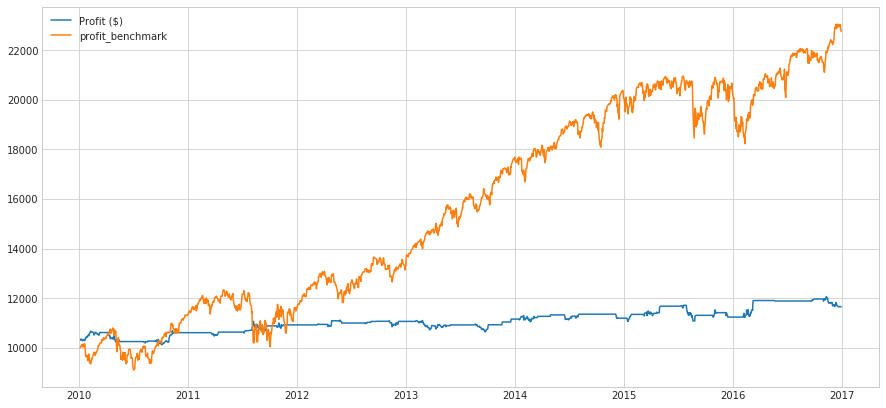

In [50]:
profit_strategy = PortfolioNetProfit(data_dict).net_profit()
PortfolioNetProfit(data_dict).curve()
qb.AddEquity('SPY')
benchmark = qb.History('SPY',start,end, Resolution.Daily).loc['SPY']['close'][in_sample_size:]
profit_benchmark = benchmark*(total_cash/benchmark[0])
plt.plot(profit_benchmark, label = 'profit_benchmark')
plt.legend()

### Step 5:
Calculatet the statistics to evaluate the performance of the strategy.
How to calculate the strategy statistics?

- *GetPortfolioStatistics(PyObject dataFrame)*

GetPortfolioStatistics API gets portfolio Statistics from a pandas.DataFrame with equity and benchmark values. The columns are 'benchmark' and 'equity'. The value is the cumulative profit of the strategy and the benchmark(buy and hold the benckmark equity strategy).

Refer to the QuantBook on Github for details:
https://github.com/QuantConnect/Lean/blob/cc46cd367f5a0c415e6ac2462b903a27a86eedcb/Jupyter/QuantBook.cs#L505

In [51]:
performance = pd.concat([profit_benchmark,profit_strategy],axis=1)[1:]
performance.columns = ['benchmark','equity']
stats = qb.GetPortfolioStatistics(performance)
stats

{u'Alpha': 0.023892686963495603,
 u'Annual Standard Deviation': 0.0449632676645482,
 u'Annual Variance': 0.0020216954390738086,
 u'Average Loss (%)': -6.07385494058071e-06,
 u'Average Win (%)': 3.5289214131427515e-05,
 u'Beta': -0.0412781383446797,
 u'Compounding Annual Return (%)': 1.76959479577068,
 u'Drawdown (%)': 5.4,
 u'Expectancy': 0.1176011149831545,
 u'Information Ratio': -0.662718759749446,
 u'Loss Rate (%)': 83.58886996024985,
 u'Net Profit (%)': 13.042780680740233,
 u'Profit-Loss Ratio': 5.8100192508143085,
 u'Sharpe Ratio': 0.4126221261601938,
 u'Tracking Error': 0.167204825369531,
 u'Treynor Ratio': -0.4494592015738769,
 u'Win Rate (%)': 16.41113003975014}